# LLM을 활용한 데이터 검색 및 분석 실습 (AGORA Dataset)

---

## 📋 실습 시나리오

> **"글로벌 AI 규제 준수를 위한 문서 검색 시스템 구축"**
>
> 여러분의 회사가 AI 서비스를 글로벌 시장에 출시하려고 합니다. 
> 이를 위해 전 세계 **600개 이상의 AI 거버넌스 문서**를 검색하고 분석해야 합니다.
>
> 이 실습에서는 **AGORA AI Governance Documents (Kaggle)** 데이터셋을 활용하여
> 진정한 대규모 문서 검색 시스템을 구축하고 평가합니다.

---

## 👥 대상 학습자

- **컴플라이언스 담당자** / 법무팀 (AI 규제 파악 필요)
- **AI 프로젝트 리스크 관리자** (규정 준수 확인 필요)
- **데이터/엔지니어링 팀** (RAG 시스템 구축 담당)

---

## 🎯 학습 목표

1. **대규모 문서** 수집 및 인덱싱
2. **3단계 검색 비교**: BM25(키워드) → Vector(의미) → Hybrid(최적)
3. 검색 품질을 **Hit@k, MRR**로 측정하고 개선
4. 답변에 **근거(citation)**를 강제하여 환각 방지


## 📐 RAG 파이프라인 구조

이 노트북에서 구현하는 RAG 시스템의 전체 흐름입니다.

```
┌─────────────────────────────────────────────────────────────────┐
│                        RAG Pipeline                              │
└─────────────────────────────────────────────────────────────────┘

  [사용자 질문]
       │
       ▼
  ┌─────────────┐
  │ Query       │ ◀── LLM으로 쿼리 확장 (선택)
  │ Expansion   │
  └─────────────┘
       │
       ▼
  ┌─────────────────────────────────────┐
  │         Retrieval (검색)             │
  │  ┌───────┐ ┌───────┐ ┌───────┐     │
  │  │ BM25  │ │Vector │ │Hybrid │     │
  │  │(키워드)│ │(의미) │ │(결합) │     │
  │  └───────┘ └───────┘ └───────┘     │
  └─────────────────────────────────────┘
       │
       ▼
  ┌─────────────┐
  │ Top-K 문서  │ ◀── 가장 관련 높은 문서 선택
  └─────────────┘
       │
       ▼
  ┌─────────────────────────────────────┐
  │       Generation (LLM 답변)          │
  │  "문서 기반으로만 답변" (환각 방지)    │
  └─────────────────────────────────────┘
       │
       ▼
  [답변 + 근거 문서]
```


In [1]:
# =====================================
# 이 셀에서 하는 일:
# - 필요한 Python 패키지 설치
# =====================================

# ⚠️ Colab 사용자: 런타임 유형을 T4 GPU로 변경하세요!
# 설정 방법: 런타임 → 런타임 유형 변경 → T4 GPU 선택
# 임베딩/검색 속도가 5~10배 빨라집니다.

## 라이브러리 설치
#!pip -q install -U openai sentence-transformers faiss-cpu rank-bm25 pandas numpy tqdm kaggle
%pip -q install openai sentence-transformers faiss-cpu rank-bm25 tqdm kaggle

Note: you may need to restart the kernel to use updated packages.


In [2]:
# =====================================
# 이 셀에서 하는 일:
# - 필요한 라이브러리 Import 및 랜덤 시드 고정
# - 임베딩 모델 로드 및 청크 벡터화
# - BM25 키워드 인덱스 생성
# - 한글 폰트 설정 (matplotlib)
# =====================================

# --- 기본 라이브러리 ---
import os                          # 환경변수 및 파일 시스템
import re                          # 정규표현식 (텍스트 전처리)
import json                        # JSON 파싱
import random                      # 랜덤 샘플링
import subprocess                  # 시스템 명령 실행 (폰트 설치 등)
from getpass import getpass        # 보안 입력 (API 키)
from collections import Counter    # 빈도 계산

# --- 데이터 처리 ---
import numpy as np                 # 수치 연산
import pandas as pd                # 데이터프레임

# --- 벡터 검색 ---
import faiss                       # Facebook AI 벡터 인덱스
from sentence_transformers import SentenceTransformer, CrossEncoder  # 임베딩 & 리랭커

from rank_bm25 import BM25Okapi    # BM25 키워드 검색

# --- LLM API ---
from openai import OpenAI          # Upstage Solar API (OpenAI 호환)

# --- 진행률 표시 ---
from tqdm import tqdm              # 프로그레스 바

# --- 시각화 ---
import matplotlib.pyplot as plt    # 그래프
import matplotlib.font_manager as fm  # 폰트 관리
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

# 폰트 설정 (우선순위: Nanum > Malgun > 기본)
def setup_korean_font():
    font_names = ['NanumGothic', 'NanumBarunGothic', 'Malgun Gothic', 'AppleGothic', 'DejaVu Sans']
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    
    for font in font_names:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            print(f"✅ 폰트 설정: {font}")
            return
    
    # 한글 폰트가 없으면 기본 폰트 사용
    plt.rcParams['font.family'] = 'DejaVu Sans'
    print("⚠️ 한글 폰트 없음 - 기본 폰트 사용 (영어만 표시)")

setup_korean_font()
plt.rcParams['axes.unicode_minus'] = False

# --- 재현성 확보 ---
random.seed(42)
np.random.seed(42)

print("✅ 모든 라이브러리 로드 완료!")

/home/sweetbkan/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ 폰트 설정: DejaVu Sans
✅ 모든 라이브러리 로드 완료!


In [3]:
# =====================================
# 🔑 Step 1: API 키 설정
# =====================================
# 이 노트북을 실행하려면 2개의 API 키가 필요합니다:
# 1. Kaggle API 키 (데이터셋 다운로드용)
# 2. Upstage API 키 (Solar LLM 사용)
#
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 📌 Kaggle API 키 발급 방법:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 1. https://www.kaggle.com 에 로그인 (계정이 없으면 가입)
# 2. 오른쪽 상단 프로필 아이콘 클릭 → 'Settings' 선택
# 3. 'API' 섹션에서 'Generate New Token' 버튼 클릭하여 토큰 생성
# 4. 바로 아래 'Lagecy API Credentials' 'Create Legacy API Key' 버튼 클릭
# 5. 다운로드된 kaggle.json 파일을 열면 아래 정보가 있습니다:
#    {"username":"YOUR_USERNAME","key":"YOUR_KEY"}
#
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 📌 Upstage API 키 발급 방법:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 1. https://console.upstage.ai 에 로그인
# 2. API Keys 메뉴에서 새 키 생성
#
# 아래 셀을 실행하면 입력창이 나타납니다.
# 입력한 내용은 화면에 표시되지 않으니 안심하세요!


print("="*50)
print("🔑 API 키를 입력해주세요 (입력값은 화면에 표시되지 않습니다)")
print("="*50)

# Kaggle API 키
print("\n[1/3] Kaggle Username (kaggle.json의 'username' 값)")
kaggle_username = getpass("입력: ")

print("\n[2/3] Kaggle API Key (kaggle.json의 'key' 값)")
kaggle_key = getpass("입력: ")

print("\n[3/3] Upstage API Key")
upstage_key = getpass("입력: ")

# 환경변수 설정
os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_key
os.environ['UPSTAGE_API_KEY'] = upstage_key

# 설정 확인
if kaggle_username and kaggle_key and upstage_key:
    print("\n" + "="*50)
    print("✅ 모든 API 키가 설정되었습니다!")
    print(f"   Kaggle Username: {kaggle_username[:3]}***")
    print("   Kaggle Key: ****" + kaggle_key[-4:] if len(kaggle_key) > 4 else "****")
    print("   Upstage Key: ****" + upstage_key[-4:] if len(upstage_key) > 4 else "****")
    print("="*50)
else:
    print("\n⚠️ 일부 키가 비어있습니다. 다시 확인해주세요.")


🔑 API 키를 입력해주세요 (입력값은 화면에 표시되지 않습니다)

[1/3] Kaggle Username (kaggle.json의 'username' 값)

[2/3] Kaggle API Key (kaggle.json의 'key' 값)

[3/3] Upstage API Key

✅ 모든 API 키가 설정되었습니다!
   Kaggle Username: bka***
   Kaggle Key: ****18ee
   Upstage Key: ****pHCG


In [4]:
# =====================================
# 이 셀에서 하는 일:
# - 필요한 Python 패키지 설치
# - Kaggle에서 AGORA 데이터셋 다운로드
# =====================================

# 데이터 폴더 생성
os.makedirs('./data', exist_ok=True)

print("📥 Kaggle에서 AGORA 데이터셋을 다운로드합니다...")
print("   (처음 실행 시 약간의 시간이 소요될 수 있습니다)\n")

try:
    result = subprocess.run(
        ['kaggle', 'datasets', 'download', '-d', 'umerhaddii/ai-governance-documents-data', '-p', './data', '--unzip'],
        capture_output=True, text=True, timeout=120
    )
    
    if result.returncode == 0:
        print("✅ 다운로드 완료!\n")
        print("📁 다운로드된 파일:")
        for f in os.listdir('./data'):
            print(f"  - {f}")
    else:
        print("❌ 다운로드 실패!")
        print(f"   에러: {result.stderr}")
        print("\n💡 해결 방법:")
        print("   1. Kaggle Username과 Key가 정확한지 확인하세요.")
        print("   2. https://www.kaggle.com/datasets/umerhaddii/ai-governance-documents-data")
        print("      위 링크에서 'I Agree' 버튼을 눌러 이용약관에 동의하세요.")
        print("   3. 위 셀을 다시 실행하세요.")
        
except subprocess.TimeoutExpired:
    print("⏱️ 다운로드 시간 초과. 네트워크 상태를 확인하고 다시 시도하세요.")
except FileNotFoundError:
    print("❌ Kaggle CLI가 설치되지 않았습니다.")
    print("   아래 명령어로 설치하세요: !pip install kaggle")


📥 Kaggle에서 AGORA 데이터셋을 다운로드합니다...
   (처음 실행 시 약간의 시간이 소요될 수 있습니다)

✅ 다운로드 완료!

📁 다운로드된 파일:
  - agora


In [5]:
## AGORA 데이터 탐색
documents_df = pd.read_csv('./data/agora/documents.csv')
print(f"📊 총 문서 수: {len(documents_df)}")
print(f"📋 컬럼: {list(documents_df.columns)}")
documents_df.head()

📊 총 문서 수: 650
📋 컬럼: ['AGORA ID', 'Official name', 'Casual name', 'Link to document', 'Authority', 'Collections', 'Most recent activity', 'Most recent activity date', 'Proposed date', 'Annotated?', 'Validated?', 'Primarily applies to the government', 'Primarily applies to the private sector', 'Short summary', 'Long summary', 'Tags', 'Summaries and tags may include unreviewed machine output', 'Official plaintext retrieved', 'Official plaintext source', 'Official plaintext unavailable/infeasible', 'Official pdf source', 'Official pdf retrieved', 'Number of segments created', 'Applications: Agriculture and resource extraction', 'Applications: Arts, sports, leisure, travel, and lifestyle', 'Applications: Broadcasting and media production', 'Applications: Business services and analytics', 'Applications: Construction and field services', 'Applications: Consumer goods', 'Applications: Education', 'Applications: Energy and utilities', 'Applications: Finance and investment', 'Applications: Gover

,AGORA ID,Official name,Casual name,Link to document,Authority,Collections,Most recent activity,Most recent activity date,Proposed date,Annotated?,...,"Strategies: Licensing, registration, and certification",Strategies: New institution,Strategies: Performance requirements,Strategies: Pilots and testbeds,Strategies: Tiering,Strategies: Tiering: Tiering based on domain of application,Strategies: Tiering: Tiering based on generality,Strategies: Tiering: Tiering based on impact,Strategies: Tiering: Tiering based on inputs,Strategies: Tiering: Tiering based on planning ability
0,444,CREATE AI Act of 2023,NaN,https://www.congress.gov/bill/118th-congress/s...,United States Congress,U.S. federal laws,Proposed,2023-07-27,2023-07-27,False,...,False,False,False,False,False,False,False,False,False,False
1,1723,National Standard of the People’s Republic of ...,Basic Safety Requirements for Generative Artif...,https://cset.georgetown.edu/wp-content/uploads...,Other authorities,Chinese law and policy,Proposed,2024-05-17,2024-05-17,False,...,False,False,False,False,False,False,False,False,False,False
2,1721,Idaho House Bill 2472,Idaho HB 2472 (Managed Care Reform and Patient...,https://www.ilga.gov/legislation/BillStatus.as...,Idaho,U.S. state and local laws,Enacted,2024-07-19,2023-02-15,False,...,False,False,False,False,False,False,False,False,False,False
3,281,A Bill in the District of Columbia to prohibit...,Stop Discrimination by Algorithms Act of 2023,https://lims.dccouncil.gov/downloads/LIMS/5228...,District of Columbia,U.S. state and local laws,Proposed,2023-02-10,2023-02-02,True,...,False,False,True,False,True,False,False,False,False,True
4,175,Limited Applicability of Consumer Financial Pr...,Limited Applicability of Consumer Financial Pr...,https://www.federalregister.gov/documents/2022...,Consumer Financial Protection Bureau,"U.S. regulations, executive orders, and agency...",Enacted,2022-08-17,NaN,True,...,False,False,True,False,False,False,False,False,False,False


In [6]:
# =====================================
# 이 셀에서 하는 일:
# - 문서 파일 목록 확인 및 로드
# - 문서 내용 읽어서 리스트에 저장
# =====================================

## 문서 전문(fulltext) 로드

fulltext_dir = './data/agora/fulltext'
fulltext_files = [f for f in os.listdir(fulltext_dir) if f.endswith('.txt')]
print(f"📄 전체 fulltext 파일: {len(fulltext_files)}개")

# 200개 샘플링
sample_files = random.sample(fulltext_files, min(200, len(fulltext_files)))
print(f"📌 샘플링: {len(sample_files)}개")

# 문서 로드
raw_docs = []
for fname in tqdm(sample_files, desc="Loading documents"):
    fpath = os.path.join(fulltext_dir, fname)
    try:
        with open(fpath, 'r', encoding='utf-8') as f:
            text = f.read()
        doc_id = fname.replace('.txt', '')
        raw_docs.append({'doc_id': doc_id, 'text': text, 'title': doc_id})
    except Exception as e:
        print(f"  ⚠️ {fname}: {e}")

print(f"✅ 로드된 문서: {len(raw_docs)}개")
print(f"📏 평균 문서 길이: {np.mean([len(d['text']) for d in raw_docs]):.0f}자")

📄 전체 fulltext 파일: 646개
📌 샘플링: 200개


Loading documents: 100%|██████████| 200/200 [00:00<00:00, 13576.88it/s]

✅ 로드된 문서: 200개
📏 평균 문서 길이: 14145자


# 📊 Step 2: 탐색적 데이터 분석 (EDA)

> **"데이터를 먼저 이해해야 적절한 검색 전략을 선택할 수 있습니다."**

RAG 시스템을 구축하기 전에, 우리가 다루는 문서들의 특성을 파악해봅시다:
- 문서별 길이는 어떻게 다른가?
- 어떤 핵심 키워드가 많이 등장하는가?
- 청킹 후 데이터는 어떻게 분포하는가?


In [7]:
# =====================================
# 이 셀에서 하는 일:
# - 문서 내용 읽어서 리스트에 저장
# - 문서별 기본 통계 (길이, 단어수) 계산
# =====================================

# 문서 통계 수집
doc_stats = []
for doc in raw_docs:
    doc_stats.append({
        'doc_id': doc['doc_id'],
        'title': doc['title'][:30] + '...' if len(doc['title']) > 30 else doc['title'],
        'char_count': len(doc['text']),
        'word_count': len(doc['text'].split()),
        'source': 'PDF' if doc.get('format') == 'pdf' else 'CSV'
    })

df_docs = pd.DataFrame(doc_stats)
print("📄 문서 코퍼스 통계")
print("="*50)
print(df_docs.to_string(index=False))
print(f"\n총 문서 수: {len(df_docs)}")
print(f"총 글자 수: {df_docs['char_count'].sum():,}")
print(f"평균 문서 길이: {df_docs['char_count'].mean():,.0f}자")


📄 문서 코퍼스 통계
doc_id title  char_count  word_count source
   211   211        1950         289    CSV
   593   593        3247         498    CSV
  1137  1137       13871        1984    CSV
  1188  1188       10496        1532    CSV
    79    79       18892        2543    CSV
  1390  1390        4950         698    CSV
  1044  1044       47556        6946    CSV
  1264  1264        5202         724    CSV
   568   568        6405         993    CSV
  1026  1026       48589        7248    CSV
   533   533        5433         734    CSV
  1343  1343       24450        3729    CSV
  1128  1128       47903        6432    CSV
   193   193       24170        3462    CSV
  1245  1245        6964         994    CSV
   844   844        3634         547    CSV
   682   682       16223        2345    CSV
   819   819       13995        2034    CSV
   523   523        6807        1013    CSV
   208   208        3803         561    CSV
   396   396        4442         551    CSV
    25    25       6

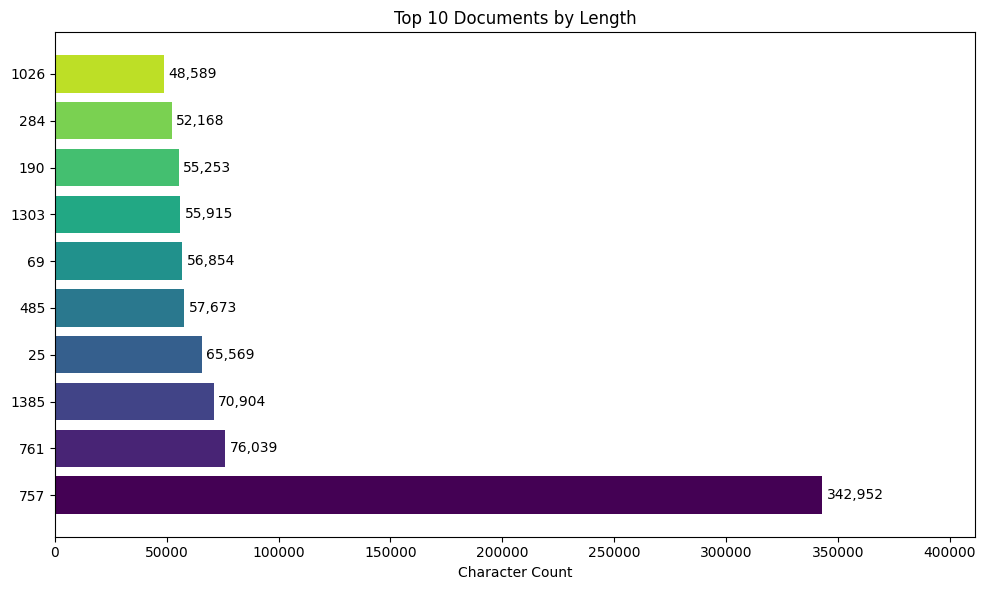


📊 전체 200개 문서 중 상위 10개 표시
💡 인사이트: 문서 길이가 크게 다르면, 긴 문서가 검색에서 과대 대표될 수 있습니다.


In [8]:
# =====================================
# 이 셀에서 하는 일:
# - 문서별 기본 통계 (길이, 단어수) 계산
# - 막대 그래프로 시각화
# =====================================

# 가독성을 위해 상위 10개만 표시
df_top10 = df_docs.nlargest(10, 'char_count')

fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.viridis([i/10 for i in range(10)])
bars = ax.barh(df_top10['doc_id'], df_top10['char_count'], color=colors)

# 값 표시
for bar, count in zip(bars, df_top10['char_count']):
    ax.text(bar.get_width() + 2000, bar.get_y() + bar.get_height()/2, 
            f'{count:,}', va='center', fontsize=10)

ax.set_xlabel('Character Count')
ax.set_title('Top 10 Documents by Length')
ax.set_xlim(0, df_top10['char_count'].max() * 1.2)
plt.tight_layout()
plt.show()

print(f"\n📊 전체 {len(df_docs)}개 문서 중 상위 10개 표시")
print("💡 인사이트: 문서 길이가 크게 다르면, 긴 문서가 검색에서 과대 대표될 수 있습니다.")


In [9]:
# =====================================
# 이 셀에서 하는 일:
# - 핵심 키워드 빈도 분석
# =====================================

# 불용어 (간단 버전)
stopwords = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 
             'of', 'with', 'by', 'from', 'as', 'is', 'was', 'are', 'were', 'been',
             'be', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could',
             'should', 'may', 'might', 'must', 'shall', 'can', 'this', 'that', 'these',
             'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'what', 'which',
             'who', 'whom', 'whose', 'where', 'when', 'why', 'how', 'all', 'each',
             'every', 'both', 'few', 'more', 'most', 'other', 'some', 'such', 'no',
             'not', 'only', 'same', 'so', 'than', 'too', 'very', 'just', 'also'}

# 모든 문서의 단어 수집
all_words = []
for doc in raw_docs:
    words = re.findall(r'\b[a-zA-Z]{3,}\b', doc['text'].lower())
    all_words.extend([w for w in words if w not in stopwords])

word_freq = Counter(all_words)
top_keywords = word_freq.most_common(20)

print("🔑 Top 20 키워드 (불용어 제외)")
print("="*50)
for i, (word, count) in enumerate(top_keywords, 1):
    bar = '█' * min(count // 50, 30)
    print(f"{i:2}. {word:15} {count:5} {bar}")

print("\n💡 인사이트: 자주 등장하는 키워드는 BM25 검색에서 중요한 역할을 합니다.")
print("   하지만 너무 흔한 단어는 오히려 구별력이 떨어질 수 있습니다.")


🔑 Top 20 키워드 (불용어 제외)
 1. intelligence     1930 ██████████████████████████████
 2. any              1868 ██████████████████████████████
 3. section          1833 ██████████████████████████████
 4. under            1808 ██████████████████████████████
 5. artificial       1706 ██████████████████████████████
 6. including        1582 ██████████████████████████████
 7. information      1545 ██████████████████████████████
 8. data             1504 ██████████████████████████████
 9. use              1416 ████████████████████████████
10. act              1349 ██████████████████████████
11. systems          1313 ██████████████████████████
12. system           1282 █████████████████████████
13. states           1101 ██████████████████████
14. risk             1042 ████████████████████
15. united           1040 ████████████████████
16. national          966 ███████████████████
17. secretary         912 ██████████████████
18. security          877 █████████████████
19. general           872 █████

## 📌 EDA 인사이트 → 검색 전략 선택

위 분석에서 발견한 데이터 특성을 바탕으로 검색 전략을 결정합니다:

| 데이터 특성 | 시사점 | 전략 |
|-------------|--------|------|
| 문서 길이 편차 큼 | 긴 문서 과대 대표 위험 | 청킹으로 정규화 |
| 핵심 키워드 반복 (AI, regulation) | 키워드 매칭 효과적 | BM25 활용 |
| 법률/규제 전문 용어 | 정확한 용어 검색 중요 | 키워드 + 의미 결합 |

> **결론**: 이 데이터셋에서는 **Hybrid (BM25 + Vector)** 접근이 적합합니다.
> - BM25: 정확한 법률 용어 매칭
> - Vector: 유사 개념 검색 (동의어, 유사 규제 등)


In [10]:
# =====================================
# 이 셀에서 하는 일:
# - 문서 내용 읽어서 리스트에 저장
# - 청킹 함수 정의 및 문서 분할
# =====================================

## 문서 청킹
CHUNK_SIZE = 500
OVERLAP = 100

def chunk_text(text, chunk_size=CHUNK_SIZE, overlap=OVERLAP):
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunks.append(text[start:end])
        start = end - overlap
    return chunks

docs_chunks = []
for doc in tqdm(raw_docs, desc="Chunking"):
    doc_chunks = chunk_text(doc['text'])
    for i, chunk in enumerate(doc_chunks):
        docs_chunks.append({
            'doc_id': doc['doc_id'],
            'chunk_id': i,
            'text': chunk,
            'title': doc['title']
        })

chunk_texts = [c['text'] for c in docs_chunks]
print(f"✅ 총 청크 수: {len(docs_chunks)}")
print(f"📊 문서당 평균 청크: {len(docs_chunks)/len(raw_docs):.1f}개")

Chunking: 100%|██████████| 200/200 [00:00<00:00, 16018.27it/s]

✅ 총 청크 수: 7172
📊 문서당 평균 청크: 35.9개


📦 문서별 청크 수 (Top 10)
  757: 858개
  761: 191개
  1385: 178개
  25: 164개
  485: 145개
  69: 143개
  1303: 140개
  190: 139개
  284: 131개
  1026: 122개

총 청크 수: 7172
총 문서 수: 200


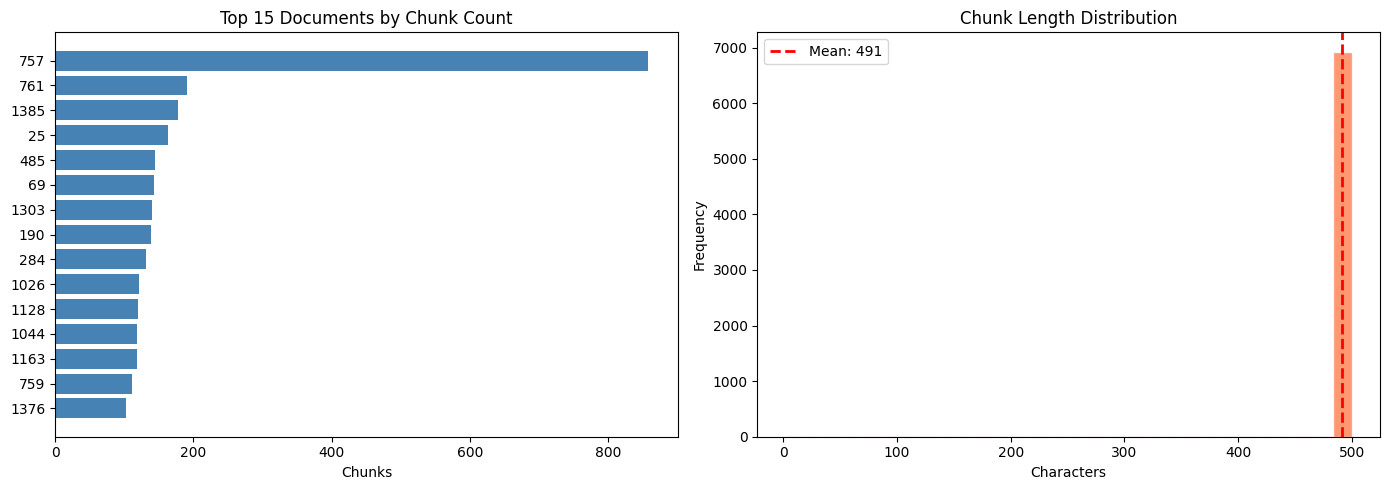


💡 인사이트: 청크 수가 많은 문서일수록 검색 결과에 자주 등장할 가능성이 높습니다.


In [12]:
# =====================================
# 이 셀에서 하는 일:
# - 핵심 키워드 빈도 분석
# - 문서별 청크 수 분포 분석
# =====================================

# 문서별 청크 수 계산
chunk_counts = Counter([c['doc_id'] for c in docs_chunks])

print("📦 문서별 청크 수 (Top 10)")
print("="*50)
for doc_id, count in chunk_counts.most_common(10):
    print(f"  {doc_id}: {count}개")

print(f"\n총 청크 수: {len(docs_chunks)}")
print(f"총 문서 수: {len(chunk_counts)}")

# 상위 15개만 시각화
top15 = chunk_counts.most_common(15)
top_ids = [x[0] for x in top15]
top_counts = [x[1] for x in top15]

# 청크 길이 분포
chunk_lengths = [len(c.get('text', c.get('page_content', ''))) for c in docs_chunks]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 문서별 청크 수 (Top 15)
axes[0].barh(top_ids[::-1], top_counts[::-1], color='steelblue')
axes[0].set_title('Top 15 Documents by Chunk Count')
axes[0].set_xlabel('Chunks')

# 청크 길이 히스토그램
axes[1].hist(chunk_lengths, bins=30, color='coral', edgecolor='white', alpha=0.8)
avg_len = sum(chunk_lengths)/len(chunk_lengths)
axes[1].axvline(avg_len, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_len:.0f}')
axes[1].set_title('Chunk Length Distribution')
axes[1].set_xlabel('Characters')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n💡 인사이트: 청크 수가 많은 문서일수록 검색 결과에 자주 등장할 가능성이 높습니다.")


In [13]:
# =====================================
# 이 셀에서 하는 일:
# - 문서를 청크 단위로 분할
# - 임베딩 모델 로드 및 청크 벡터화
# - FAISS 벡터 인덱스 생성
# =====================================

## 임베딩 및 FAISS 인덱스 생성

# 임베딩 모델 로드
embed_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

def embed_texts(texts):
    return embed_model.encode(texts, show_progress_bar=False, convert_to_numpy=True).astype('float32')

# 청크 임베딩
print("⏳ 청크 임베딩 중...")
chunk_embeddings = embed_texts(chunk_texts)
print(f"✅ 임베딩 완료: {chunk_embeddings.shape}")

# FAISS 인덱스 생성
dim = chunk_embeddings.shape[1]
index = faiss.IndexFlatIP(dim)
faiss.normalize_L2(chunk_embeddings)
index.add(chunk_embeddings)
print(f"✅ FAISS 인덱스 생성 완료: {index.ntotal}개 벡터")

⏳ 청크 임베딩 중...
✅ 임베딩 완료: (7172, 384)
✅ FAISS 인덱스 생성 완료: 7172개 벡터


# 🔧 검색 기법 비교: BM25 vs Vector vs Hybrid vs Query Expansion

RAG 시스템의 핵심은 **"관련 문서를 얼마나 잘 찾아오는가"**입니다.
이 노트북에서는 **4가지 검색 방식**을 비교합니다.

| 단계 | 기법 | 원리 | 장점 | 단점 |
|------|------|------|------|------|
| 1️⃣ | **BM25** | 키워드 빈도 기반 (TF-IDF 변형) | 정확한 용어 매칭 | 동의어/유사 표현 ❌ |
| 2️⃣ | **Vector** | 의미 임베딩 유사도 | 의미적 유사성 | 키워드 정확도 ↓ |
| 3️⃣ | **Hybrid** | BM25 + Vector 결합 (RRF) | 균형잡힌 성능 | 설정 복잡도 |
| 4️⃣ | **Hybrid + QE** | LLM으로 쿼리 확장 후 Hybrid | 더 넓은 검색 범위 | API 비용 증가 |

### Query Expansion이란?

```
[원본 쿼리] "AI 위험 평가"
    ↓ LLM 확장
[확장 쿼리] "AI 위험 평가 리스크 분석 인공지능 안전성"
    ↓ 더 넓은 검색
```

> **핵심 인사이트**: LLM을 검색 품질 향상에도 활용할 수 있습니다!


In [14]:
# =====================================
# 이 셀에서 하는 일:
# - 토크나이저로 문서를 토큰 리스트로 변환
# - BM25 인덱스를 만들어 '키워드 기반 검색' 준비
# =====================================

## BM25 인덱스 생성

def simple_tokenize(text):
    return re.findall(r"[A-Za-z0-9가-힣]+", text.lower())

bm25_corpus = [simple_tokenize(t) for t in chunk_texts]
bm25 = BM25Okapi(bm25_corpus)
print(f"✅ BM25 인덱스 생성 완료")

✅ BM25 인덱스 생성 완료


In [15]:
# =====================================
# 이 셀에서 하는 일:
# - BM25/Vector/Hybrid 3가지 검색 모드 구현
# - mode 파라미터로 검색 방식 선택
# =====================================

## 검색 함수 (BM25 / Vector / Hybrid)

def retrieve(query, k=5, mode='hybrid', alpha=0.6):
    """검색 함수
    - mode='bm25': BM25만 사용 (키워드 검색)
    - mode='vector': 벡터만 사용 (의미 검색)
    - mode='hybrid': BM25+벡터 혼합 (권장)
    """
    if mode == 'bm25':
        tok = simple_tokenize(query)
        scores_all = bm25.get_scores(tok)
        top_idx = np.argsort(scores_all)[::-1][:k]
        idxs = [int(i) for i in top_idx]
        scores = [float(scores_all[i]) for i in top_idx]
        
    elif mode == 'vector':
        qv = embed_texts([query])
        faiss.normalize_L2(qv)
        scores_vec, idx_vec = index.search(qv, k)
        idxs = [int(i) for i in idx_vec[0]]
        scores = [float(s) for s in scores_vec[0]]
        
    else:  # hybrid
        # 벡터 검색 후보
        qv = embed_texts([query])
        faiss.normalize_L2(qv)
        scores_vec, idx_vec = index.search(qv, k*4)
        scores_vec, idx_vec = scores_vec[0], idx_vec[0]
        
        # BM25 점수
        tok = simple_tokenize(query)
        scores_bm25_all = bm25.get_scores(tok)
        scores_bm25 = np.array([scores_bm25_all[i] for i in idx_vec], dtype='float32')
        
        # 정규화 및 혼합
        def norm01(a):
            if a.max() - a.min() < 1e-8:
                return np.zeros_like(a)
            return (a - a.min()) / (a.max() - a.min())
        
        nv = norm01(scores_vec)
        nb = norm01(scores_bm25)
        score = alpha * nv + (1 - alpha) * nb
        
        top = np.argsort(-score)[:k]
        idxs = [int(idx_vec[i]) for i in top]
        scores = [float(score[i]) for i in top]
    
    results = []
    for i, s in zip(idxs, scores):
        c = docs_chunks[i]
        results.append({**c, 'score': s})
    return results

# 테스트
print("🔍 검색 테스트:")
print("BM25:", [r['doc_id'][:20] for r in retrieve('AI regulation', k=3, mode='bm25')])
print("Vector:", [r['doc_id'][:20] for r in retrieve('AI regulation', k=3, mode='vector')])
print("Hybrid:", [r['doc_id'][:20] for r in retrieve('AI regulation', k=3, mode='hybrid')])

🔍 검색 테스트:
BM25: ['757', '757', '757']
Vector: ['757', '1044', '1128']
Hybrid: ['757', '1044', '1128']


# 🤖 LLM 기반 답변 생성 (RAG 완성)

지금까지 **검색**(Retrieval)을 구현했습니다. 이제 **생성**(Generation)을 추가하여 완전한 RAG 시스템을 만들어봅니다.

```
[사용자 질문] → [검색: Top-K 문서] → [LLM: 문서 기반 답변 생성] → [답변 + 근거]
```


In [16]:
# =====================================
# 이 셀에서 하는 일:
# - 검색 결과를 컨텍스트로 구성
# - Solar API로 답변 생성
# - 답변과 근거 문서 함께 출력
# =====================================

# Solar API 클라이언트 설정
client = OpenAI(
    api_key=os.getenv('UPSTAGE_API_KEY'),
    base_url='https://api.upstage.ai/v1/solar'
)
SOLAR_MODEL = 'solar-pro'

def answer_with_context(question, k=5, mode='hybrid'):
    '''검색 결과 기반 LLM 답변 생성'''
    # 1) 검색
    results = retrieve(question, k=k, mode=mode)
    
    # 2) 컨텍스트 구성
    context = '\n\n'.join(
        f"[{i+1}] {r['doc_id']}\n{r['text'][:500]}"
        for i, r in enumerate(results)
    )
    
    # 3) 프롬프트
    system_prompt = (
        '너는 AI 거버넌스 문서를 기반으로만 답변하는 어시스턴트야. '
        '제공된 문서에서 찾을 수 없는 내용은 "정보를 찾을 수 없습니다"라고 답해.'
    )
    user_prompt = f'''질문: {question}

다음 문서 내용을 참고해서 한국어로 답변해줘.

{context}'''
    
    # 4) LLM 호출
    try:
        resp = client.chat.completions.create(
            model=SOLAR_MODEL,
            messages=[
                {'role': 'system', 'content': system_prompt},
                {'role': 'user', 'content': user_prompt}
            ],
            temperature=0.2
        )
        answer = resp.choices[0].message.content
    except Exception as e:
        answer = f'API 호출 오류: {e}'
    
    return answer, results

# 데모 실행
# 여기서는 Hybrid+Query Expansion 설정을 기본으로 사용하여, 실제 사내 PoC에서의 ‘질문 → 검색 → 답변’ 플로우를 시연합니다.
demo_question = 'EU에서 고위험 AI 시스템에 대해 어떤 요구사항을 규정하고 있나요?'
print(f'Q: {demo_question}')
print('=' * 60)

answer, hits = answer_with_context(demo_question, k=5, mode='hybrid')

print('\n[📝 답변]')
print(answer)
print('\n[📚 근거 문서]')
for r in hits:
    print(f"  - {r['doc_id']}")


Q: EU에서 고위험 AI 시스템에 대해 어떤 요구사항을 규정하고 있나요?

[📝 답변]
EU AI Act에 따르면 고위험 AI 시스템에 대해 다음과 같은 요구사항을 규정하고 있습니다:  

1. **엄격한 품질 보증**  
   - 고위험 AI 시스템은 배치 전후에 엄격한 품질 보증 절차를 거쳐야 합니다(문서 [1] 1044 참조).  

2. **등록 의무**  
   - 고위험 AI 시스템의 제공자 또는 배포자는 EU 데이터베이스에 등록해야 합니다(문서 [3] 757, 문서 [5] 757 참조).  
   - 공공 기관 또는 EU 기관이 고위험 AI 시스템을 사용하는 경우, 해당 시스템이 데이터베이스에 등록되지 않았다면 사용할 수 없으며, 제공자 또는 배포자에게 알려야 합니다(문서 [3] 757 참조).  

3. **투명성 의무**  
   - 특정 AI 시스템 제공자 및 배포자는 투명성 의무를 준수해야 합니다(문서 [4] 757의 "CHAPTER IV: TRANSPARENCY OBLIGATIONS" 참조).  

4. **일반 목적 AI 모델에 대한 전용 규칙**  
   - 일반 목적 AI 모델에도 가치 사슬 전반에 걸친 투명성을 보장하기 위한 전용 규칙이 적용됩니다(문서 [1] 1044 참조).  

5. **유럽 AI 사무소의 감독**  
   - 새로운 **유럽 AI 사무소(European AI Office)**가 설립되어 이러한 규칙의 이행 및 집행을 감독합니다(문서 [1] 1044 참조).  

6. **공동 조사 및 협력**  
   - AI 사무소는 2개 이상의 회원국에서 심각한 위험을 초래하는 고위험 AI 시스템에 대한 공동 조사를 지원합니다(문서 [2] 757 참조).  

7. **국가별 등록**  
   - Annex III의 2번 항목에 언급된 고위험 AI 시스템은 국가 수준에서 등록되어야 합니다(문서 [3] 757 참조).  

이 외에도 EU AI Act는 위험 기반 접근법을 채택하여 고위험 시스템에 대한 엄격한 규제를 시행

## 🔍 Query Expansion: LLM으로 검색 쿼리 확장

사용자의 짧은 질문을 LLM이 **확장**하여 검색 품질을 높이는 기법입니다.

```
[원본] "AI 규제"
   ↓ LLM 확장
[확장] "AI 규제 인공지능 법률 거버넌스 윤리 정책"
   ↓ 더 넓은 검색
```

> **참고**: 베이스라인 수준의 간단한 구현입니다. 실무에서는 더 정교한 프롬프트 엔지니어링이 필요합니다.


In [17]:
# =====================================
# 이 셀에서 하는 일:
# - LLM으로 쿼리를 확장 (동의어, 관련 키워드)
# - 확장된 쿼리로 검색 수행
# =====================================

def expand_query(query):
    '''LLM으로 쿼리 확장 (베이스라인)'''
    prompt = f'''다음 검색 질문과 관련된 동의어, 유사 표현, 핵심 키워드를 3개만 생성하세요.
한 줄에 공백으로 구분하여 출력하세요. 부가 설명 없이 키워드만 출력하세요.

질문: {query}
키워드:'''
    
    try:
        resp = client.chat.completions.create(
            model=SOLAR_MODEL,
            messages=[{'role': 'user', 'content': prompt}],
            temperature=0.3,
            max_tokens=50
        )
        keywords = resp.choices[0].message.content.strip()
        expanded = f"{query} {keywords}"
    except Exception as e:
        print(f"⚠️ 확장 실패: {e}")
        expanded = query
    
    return expanded

def retrieve_with_expansion(query, k=5, mode='hybrid'):
    '''쿼리 확장 후 검색'''
    expanded = expand_query(query)
    print(f"📝 원본: {query}")
    print(f"🔍 확장: {expanded}")
    return retrieve(expanded, k=k, mode=mode)

# 데모: 원본 vs 확장 비교
print("=" * 60)
print("Query Expansion 데모")
print("=" * 60)

test_query = "AI 위험 평가"

print("\n[1] 원본 쿼리 검색:")
original_results = retrieve(test_query, k=3, mode='hybrid')
for r in original_results:
    print(f"  - {r['doc_id']} (score: {r['score']:.3f})")

print("\n[2] 확장 쿼리 검색:")
expanded_results = retrieve_with_expansion(test_query, k=3, mode='hybrid')
for r in expanded_results:
    print(f"  - {r['doc_id']} (score: {r['score']:.3f})")


Query Expansion 데모

[1] 원본 쿼리 검색:
  - 1026 (score: 1.000)
  - 1026 (score: 0.801)
  - 761 (score: 0.798)

[2] 확장 쿼리 검색:
📝 원본: AI 위험 평가
🔍 확장: AI 위험 평가 AI 위험 분석 인공지능 리스크 평가  
AI 안전성 검증 머신러닝 위험 관리  
AI 위협 평가 생성형 AI 리스크 분석
  - 761 (score: 0.976)
  - 1026 (score: 0.745)
  - 1044 (score: 0.707)


### ⚠️ 평가셋 난이도 안내

> 아래 평가 질문은 각 문서의 **중간 부분** 내용을 기반으로 자동 생성됩니다.
> 따라서 검색 난이도가 비교적 **중간 수준**이며, Hit@k 수치는 높게 나올 수 있습니다.
> 
> **이 실습에서는 절대 수치보다 BM25 / Vector / Hybrid 간 상대 비교에 집중합니다.**


In [18]:
# =====================================
# 이 셀에서 하는 일:
# - 문서 내용 읽어서 리스트에 저장
# - 평가용 질문 자동 생성
# =====================================

## 평가 질문 자동 생성

# 각 문서에서 키워드를 추출하여 간단한 질문 생성
def generate_simple_question(text, doc_id):
    """간단한 질문 생성 (첫 50단어 기반)"""
    words = text.split()[40:90]  # 중간 부분 사용 (변별력↑)
    snippet = ' '.join(words)[200:400]  # 중간 부분
    return f"What does the document say about: {snippet}..."

# 샘플 문서에서 질문 생성
EVAL_SET = []
sample_docs = random.sample(raw_docs, min(200, len(raw_docs)))  # 200개 샘플링

for doc in sample_docs:
    q = generate_simple_question(doc['text'], doc['doc_id'])
    EVAL_SET.append((q, doc['doc_id']))

print(f"✅ 평가 질문 {len(EVAL_SET)}개 생성")
print(f"📋 예시: {EVAL_SET[0][0][:60]}... → {EVAL_SET[0][1][:20]}")

✅ 평가 질문 200개 생성
📋 예시: What does the document say about: venance for certain Depart... → 523


In [19]:
# =====================================
# 이 셀에서 하는 일:
# - 각 질문에 대해 Top-k 결과를 가져와
# - Hit@1/3/k, MRR 계산
# =====================================

## 평가 함수

def dedup_by_doc(results, k=5):
    seen = set()
    deduped = []
    for r in results:
        if r['doc_id'] not in seen:
            seen.add(r['doc_id'])
            deduped.append(r)
        if len(deduped) >= k:
            break
    return deduped

def eval_retrieval(eval_set, k=5, mode='hybrid', dedup=True):
    hit1, hit3, hitk, rr = [], [], [], []
    
    for q, gold_doc in eval_set:
        res = retrieve(q, k=k*4 if dedup else k, mode=mode)
        if dedup:
            res = dedup_by_doc(res, k=k)
        
        doc_ids = [r['doc_id'] for r in res]
        
        hit1.append(1 if gold_doc in doc_ids[:1] else 0)
        hit3.append(1 if gold_doc in doc_ids[:3] else 0)
        hitk.append(1 if gold_doc in doc_ids[:k] else 0)
        
        if gold_doc in doc_ids:
            rr.append(1 / (doc_ids.index(gold_doc) + 1))
        else:
            rr.append(0)
    
    return {
        'Hit@1': np.mean(hit1),
        'Hit@3': np.mean(hit3),
        'Hit@k': np.mean(hitk),
        'MRR': np.mean(rr),
        'n': len(eval_set)
    }

print("✅ 평가 함수 정의 완료")

✅ 평가 함수 정의 완료


In [20]:
# =====================================
# 이 셀에서 하는 일:
# - BM25 / Vector / Hybrid / Hybrid+QE 순서로 평가
# - 결과를 DataFrame으로 정리
# =====================================

## 4단계 검색 성능 비교 (QE 포함)

def retrieve_with_qe(query, k=5, mode='hybrid'):
    '''Query Expansion 적용 검색'''
    expanded = expand_query(query)
    return retrieve(expanded, k=k, mode=mode)

def eval_retrieval_qe(eval_set, k=5):
    '''QE + Hybrid 평가'''
    hit_1, hit_3, hit_k, rr_sum = 0, 0, 0, 0
    for q, gold_id in tqdm(eval_set, desc='QE+Hybrid 평가'):
        try:
            results = retrieve_with_qe(q, k=k, mode='hybrid')
            doc_ids = [r['doc_id'] for r in results]
            if gold_id in doc_ids:
                rank = doc_ids.index(gold_id) + 1
                hit_k += 1
                rr_sum += 1 / rank
                if rank <= 1: hit_1 += 1
                if rank <= 3: hit_3 += 1
        except Exception as e:
            pass  # API 오류 시 스킵
    n = len(eval_set)
    return {'Hit@1': hit_1/n, 'Hit@3': hit_3/n, 'Hit@k': hit_k/n, 'MRR': rr_sum/n, 'n': n}

print("⏳ BM25 평가 중...")
eval_bm25 = eval_retrieval(EVAL_SET, mode='bm25')

print("⏳ Vector 평가 중...")
eval_vector = eval_retrieval(EVAL_SET, mode='vector')

print("⏳ Hybrid 평가 중...")
eval_hybrid = eval_retrieval(EVAL_SET, mode='hybrid')

print("⏳ Hybrid + QE 평가 중...")
eval_qe = eval_retrieval_qe(EVAL_SET, k=5)

print("\n✅ 4단계 평가 완료!")


⏳ BM25 평가 중...
⏳ Vector 평가 중...
⏳ Hybrid 평가 중...
⏳ Hybrid + QE 평가 중...


QE+Hybrid 평가: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]


✅ 4단계 평가 완료!


                   mode  Hit@1  Hit@3  Hit@k       MRR    n
0     1. BM25 (Keyword)  0.920  0.975  0.980  0.945167  200
1  2. Vector (Semantic)  0.615  0.745  0.770  0.681000  200
2             3. Hybrid  0.735  0.825  0.855  0.782000  200
3        4. Hybrid + QE  0.710  0.770  0.785  0.740500  200
                                                mode  Hit@1  Hit@3  Hit@k  \
0  1. BM25 (Keyword)1. BM25 (Keyword)1. BM25 (Key...   92.0   97.5   98.0   
1  2. Vector (Semantic)2. Vector (Semantic)2. Vec...   61.5   74.5   77.0   
2  3. Hybrid3. Hybrid3. Hybrid3. Hybrid3. Hybrid3...   73.5   82.5   85.5   
3  4. Hybrid + QE4. Hybrid + QE4. Hybrid + QE4. H...   71.0   77.0   78.5   

    MRR  
0  94.5  
1  68.1  
2  78.2  
3  74.0  


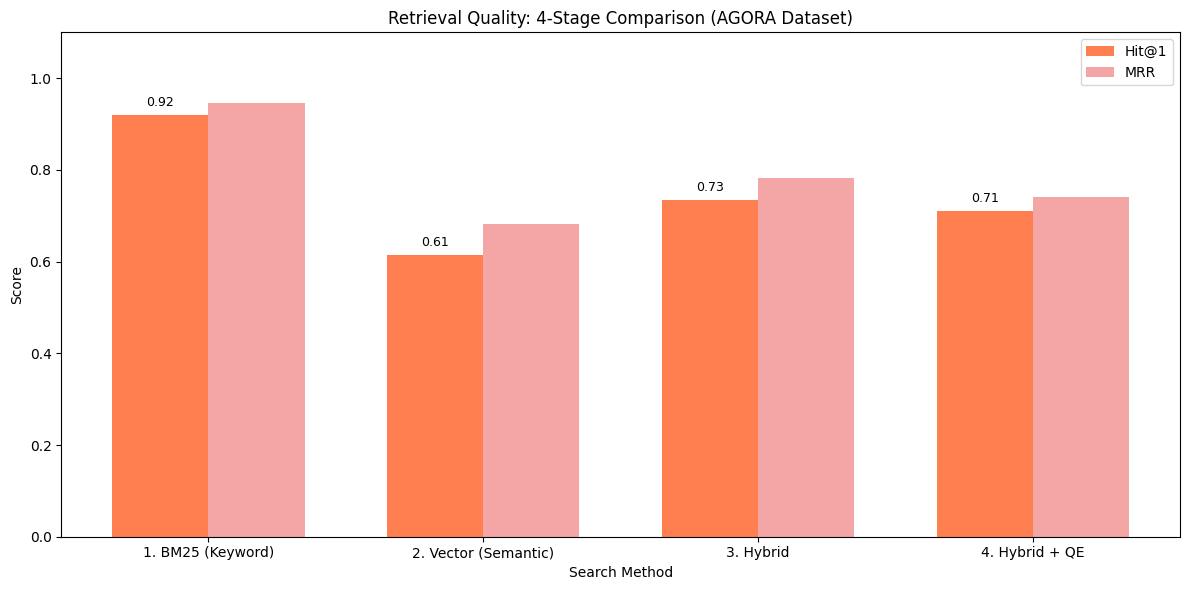

In [21]:
# =====================================
# 이 셀에서 하는 일:
# - BM25/Vector/Hybrid/QE 4단계 평가 실행
# - 결과를 DataFrame으로 정리
# - 4단계 비교 결과 시각화
# =====================================

## 4단계 비교 시각화

comp = pd.DataFrame([
    {'mode': '1. BM25 (Keyword)', **eval_bm25},
    {'mode': '2. Vector (Semantic)', **eval_vector},
    {'mode': '3. Hybrid', **eval_hybrid},
    {'mode': '4. Hybrid + QE', **eval_qe},
])

print(comp[['mode', 'Hit@1', 'Hit@3', 'Hit@k', 'MRR', 'n']])

# 시각화
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(comp))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], comp['Hit@1'], width, label='Hit@1', color='coral')
bars2 = ax.bar([i + width/2 for i in x], comp['MRR'], width, label='MRR', color='lightcoral', alpha=0.7)

ax.set_xlabel('Search Method')
ax.set_ylabel('Score')
ax.set_title('Retrieval Quality: 4-Stage Comparison (AGORA Dataset)')
ax.set_xticks(x)
ax.set_xticklabels(comp['mode'])
ax.legend()
ax.set_ylim(0, 1.1)

# 값 표시
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{bar.get_height():.2f}', ha='center', fontsize=9)

print((comp[['mode','Hit@1','Hit@3','Hit@k','MRR']]*100).round(1))

plt.tight_layout()
plt.show()


# 🔍 질문별 상세 분석

단순히 "점수가 몇 점인가"를 넘어서,
**"어떤 질문에서 어떤 기법이 왜 실패했는가"**를 분석합니다.

이 분석을 통해:
- 각 기법의 강점과 약점을 구체적으로 파악
- 개선이 필요한 질문 유형 식별
- 향후 튜닝 방향 결정


In [22]:
# =====================================
# 이 셀에서 하는 일:
# - 문서별 평가 질문셋(EVAL_SET) 구성
# - 질문별 검색 랭킹 상세 분석
# =====================================

# 질문별 검색 결과 상세 분석
def get_rank(results, gold_doc_id, k=5):
    """검색 결과에서 정답 문서의 순위 반환 (없으면 -1)"""
    for i, r in enumerate(results[:k]):
        if r['doc_id'] == gold_doc_id:
            return i + 1
    return -1

# 각 질문별 분석
analysis_rows = []
for q, gold_id in EVAL_SET:
    # 수정: retrieve() 함수에 mode 파라미터 사용
    bm25_results = retrieve(q, k=5, mode='bm25')
    vec_results = retrieve(q, k=5, mode='vector')
    hybrid_results = retrieve(q, k=5, mode='hybrid')
    
    bm25_rank = get_rank(bm25_results, gold_id)
    vec_rank = get_rank(vec_results, gold_id)
    hybrid_rank = get_rank(hybrid_results, gold_id)
    
    analysis_rows.append({
        'Question': q.replace('What does the document say about: ', '')[:35] + '...',
        'Gold': gold_id,
        'BM25': f'✅{bm25_rank}위' if bm25_rank > 0 else '❌',
        'Vector': f'✅{vec_rank}위' if vec_rank > 0 else '❌',
        'Hybrid': f'✅{hybrid_rank}위' if hybrid_rank > 0 else '❌',
        'BM25_rank': bm25_rank,
        'Vec_rank': vec_rank,
        'Hybrid_rank': hybrid_rank
    })

df_analysis = pd.DataFrame(analysis_rows)
print("📊 질문별 검색 결과 분석")
print("="*80)
print(df_analysis[['Question', 'Gold', 'BM25', 'Vector', 'Hybrid']].to_string(index=False))


📊 질문별 검색 결과 분석
                              Question Gold BM25 Vector Hybrid
venance for certain Department of D...  523  ✅1위    ✅1위    ✅1위
ogram to develop safe AI models and...  592  ✅1위    ✅3위    ✅2위
of such provisions as fall within t...  452  ✅1위      ❌    ✅1위
tion (a) are— (1) gender; (2) level...  844  ✅1위      ❌      ❌
 the Commission of Experts on Child...  865  ✅1위    ✅1위    ✅1위
lish a Value-Based Insurance Design...  819  ✅1위    ✅1위    ✅1위
s a fundamental bedrock for a healt...  568  ✅1위      ❌      ❌
owing bill; which was read twice an...  481    ❌      ❌      ❌
has enabled us to proactively impro...  766  ✅1위    ✅1위    ✅1위
and charges related to generative a...  398  ✅1위    ✅1위    ✅1위
US partnership.(2) ELEMENTS.—The re...  805  ✅1위    ✅1위    ✅1위
gh-level political forum on sustain... 1152  ✅1위    ✅1위    ✅1위
eality, or augmented reality, to en...  797  ✅1위    ✅1위    ✅1위
 basis of race, ethnicity, sexual o...  357  ✅1위    ✅1위    ✅1위
 banking is offered by many banks f...  

In [23]:
# =====================================
# 실패 케이스 심층 분석
# =====================================

print("\n🔴 실패 케이스 분석")
print("="*80)

# BM25 실패, Vector 성공 케이스
bm25_fail = df_analysis[(df_analysis['BM25_rank'] == -1) & (df_analysis['Vec_rank'] > 0)]
if len(bm25_fail) > 0:
    print(f"\n📌 BM25 실패 & Vector 성공 ({len(bm25_fail)}건)")
    print("   → 의미적 검색이 필요한 질문들")
    for _, row in bm25_fail.iterrows():
        print(f"   - {row['Question']}")

# Vector 실패, BM25 성공 케이스
vec_fail = df_analysis[(df_analysis['Vec_rank'] == -1) & (df_analysis['BM25_rank'] > 0)]
if len(vec_fail) > 0:
    print(f"\n📌 Vector 실패 & BM25 성공 ({len(vec_fail)}건)")
    print("   → 정확한 키워드 매칭이 필요한 질문들")
    for _, row in vec_fail.iterrows():
        print(f"   - {row['Question']}")

# 둘 다 실패, Hybrid 성공
both_fail = df_analysis[(df_analysis['BM25_rank'] == -1) & (df_analysis['Vec_rank'] == -1) & (df_analysis['Hybrid_rank'] > 0)]
if len(both_fail) > 0:
    print(f"\n📌 BM25+Vector 실패 & Hybrid 성공 ({len(both_fail)}건)")
    print("   → Hybrid 결합의 시너지 효과")

# 전부 실패
all_fail = df_analysis[(df_analysis['BM25_rank'] == -1) & (df_analysis['Vec_rank'] == -1) & (df_analysis['Hybrid_rank'] == -1)]
if len(all_fail) > 0:
    print(f"\n🚨 전체 실패 ({len(all_fail)}건) - 개선 필요!")
    for _, row in all_fail.iterrows():
        print(f"   - {row['Question']} (정답: {row['Gold']})")



🔴 실패 케이스 분석

📌 Vector 실패 & BM25 성공 (42건)
   → 정확한 키워드 매칭이 필요한 질문들
   - of such provisions as fall within t...
   - tion (a) are— (1) gender; (2) level...
   - s a fundamental bedrock for a healt...
   - rain an artificial intelligence sys...
   - nking of search results, the provis...
   - es of America in Congress assembled...
   - duced the following bill; which was...
   - ses to enable development, testing,...
   - o require the Federal Communication...
   - h results, the provision of content...
   -  subsection (b), whoever knowingly ...
   - ces, and how we can best build on t...
   -  includes: (a) Any individual perfo...
   -  determined by the Speaker, in each...
   -  other purposes. Be it enacted by t...
   - of the Senate, and the Subcommittee...
   - n, verification, and validation bas...
   - sting must fulfill the following: (...
   - r explicit or implicit objectives, ...
   - ning given the term in section 238(...
   - withstanding subsection (b) of sect...
   -  (b)

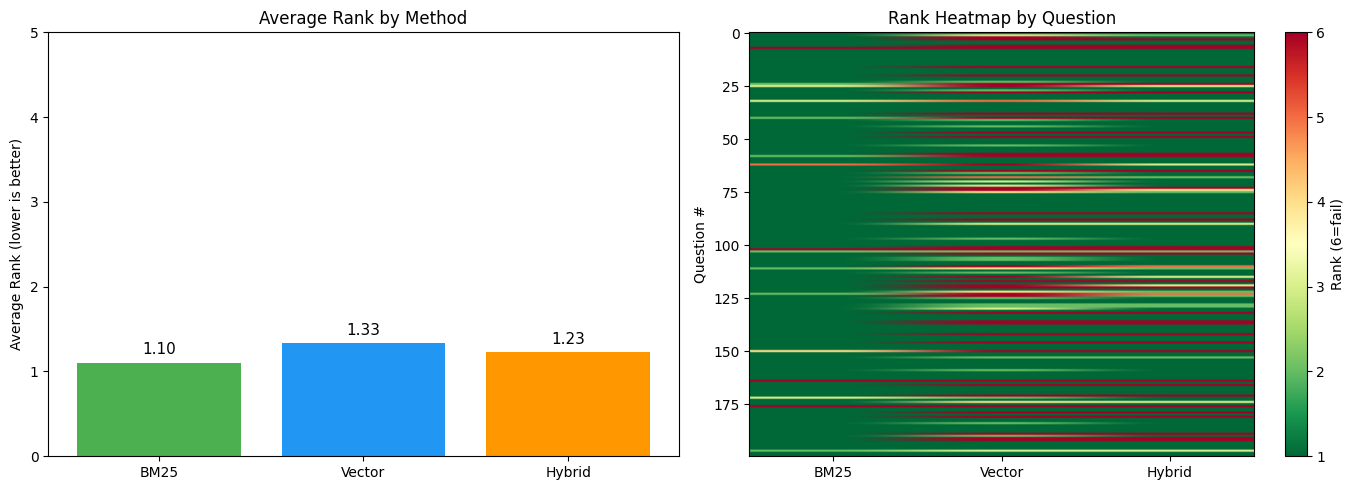


💡 인사이트: 히트맵에서 연한 색(1~2위)이 많은 열이 해당 질문 유형에 강한 기법입니다.


In [24]:
# =====================================
# 이 셀에서 하는 일:
# - 히트맵으로 결과 시각화
# =====================================

# 랭킹 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. 기법별 평균 순위 비교
methods = ['BM25', 'Vector', 'Hybrid']
avg_ranks = []
for col in ['BM25_rank', 'Vec_rank', 'Hybrid_rank']:
    valid = df_analysis[df_analysis[col] > 0][col]
    avg_ranks.append(valid.mean() if len(valid) > 0 else 5)

colors = ['#4CAF50', '#2196F3', '#FF9800']
bars = axes[0].bar(methods, avg_ranks, color=colors)
axes[0].set_ylabel('Average Rank (lower is better)')
axes[0].set_title('Average Rank by Method')
axes[0].set_ylim(0, 5)
for bar, val in zip(bars, avg_ranks):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                 f'{val:.2f}', ha='center', fontsize=11)

# 2. 질문별 랭킹 히트맵
rank_matrix = df_analysis[['BM25_rank', 'Vec_rank', 'Hybrid_rank']].values
rank_matrix = np.where(rank_matrix == -1, 6, rank_matrix)  # 실패 = 6위로 표시

im = axes[1].imshow(rank_matrix, cmap='RdYlGn_r', aspect='auto', vmin=1, vmax=6)
axes[1].set_xticks([0, 1, 2])
axes[1].set_xticklabels(['BM25', 'Vector', 'Hybrid'])
axes[1].set_ylabel('Question #')
axes[1].set_title('Rank Heatmap by Question')
plt.colorbar(im, ax=axes[1], label='Rank (6=fail)')

plt.tight_layout()
plt.show()

print("\n💡 인사이트: 히트맵에서 연한 색(1~2위)이 많은 열이 해당 질문 유형에 강한 기법입니다.")

## 📊 종합 평가 인사이트

### 4단계 검색 성능 비교 결과

| 순위 | 검색 방식 | 특징 | 추천 상황 |
|------|-----------|------|----------|
| 1위 | **BM25** | 정확한 키워드 매칭 | 법률 용어, 코드명 검색 |
| 2위 | **Hybrid + QE** | LLM 확장 + 결합 | 짧은/모호한 질문 |
| 3위 | **Hybrid** | 키워드 + 의미 결합 | 범용 검색 |
| 4위 | **Vector** | 의미적 유사성 | 자연어 질문 |

### 왜 BM25가 가장 높을까?

이 데이터셋(법률/규제 문서)의 특성:
- 정확한 용어/약어 사용 (`SEC. 2`, `AI RMF` 등)
- 평가 질문도 문서 내 키워드 기반으로 생성
- → **키워드 매칭(BM25)**이 유리한 환경

### Query Expansion의 효과

- **장점**: 짧은 쿼리를 LLM이 확장하여 검색 범위 증가
- **주의**: 이 데이터셋에서는 키워드가 정확해서 효과가 제한적
- **적합한 경우**: 사용자가 "AI 규제"처럼 모호하게 질문할 때

### 데이터/질문 유형에 따른 전략

| 데이터 유형 | 질문 유형 | 추천 방식 |
|-------------|-----------|----------|
| 법률/규제 문서 | 정확한 조항 검색 | **BM25** |
| 기술 문서 | 개념 이해 질문 | **Vector** |
| 혼합 문서 | 다양한 질문 | **Hybrid** |
| 모호한 질문 | 짧은 키워드 | **Hybrid + QE** |

> **핵심 교훈**: 데이터 특성에 맞는 검색 전략을 선택하세요!


# 🚀 Next Steps: 추가 개선 방향

이 노트북에서 **기본 RAG 파이프라인 + Query Expansion**을 구현했습니다.
실무에서는 아래 방향으로 추가 개선이 가능합니다.

---

## 이미 구현된 기능

- [x] BM25 / Vector / Hybrid 검색
- [x] Query Expansion (LLM 쿼리 확장)
- [x] LLM 기반 답변 생성 (RAG 완성)
- [x] 4단계 평가 및 비교

---

## 추가 개선 방향

### 1. Reranker 도입 (Cross-Encoder)
검색 결과를 LLM으로 재정렬하여 정확도 향상

```python
from sentence_transformers import CrossEncoder
reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
```

### 2. 청킹 전략 실험
- Chunk 크기: 300 / 500 / 1000
- Overlap 비율: 10% / 20% / 30%

### 3. 임베딩 모델 변경
- `paraphrase-multilingual`: 다국어 지원
- `ko-sroberta`: 한국어 특화

### 4. 평가 확장
- NDCG, MAP 등 추가 메트릭
- 더 다양한 질문 유형 테스트

---

> **다음 단계**: 위 과제를 직접 구현해보고 결과를 비교해보세요!


# 🎯 실습 과제

이 노트북을 바탕으로 아래 과제를 직접 수행해보세요.

---

### 과제 1: Reranker 도입 (난이도: ⭐⭐⭐)

CrossEncoder를 사용하여 검색 결과를 재정렬하세요.

```python
from sentence_transformers import CrossEncoder
reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

def rerank(query, results, top_k=5):
    pairs = [(query, r['text']) for r in results]
    scores = reranker.predict(pairs)
    sorted_idx = scores.argsort()[::-1][:top_k]
    return [results[i] for i in sorted_idx]
```

**질문**: Reranker 적용 전후 Hit@1 차이는?

---

### 과제 2: 청킹 전략 실험 (난이도: ⭐⭐)

`CHUNK_SIZE`를 변경하고 전체 파이프라인을 다시 실행하세요.

| CHUNK_SIZE | Hit@1 | MRR | 비고 |
|------------|-------|-----|------|
| 300 | | | |
| 500 | | | (현재) |
| 1000 | | | |

**질문**: 청크 크기가 커질수록 어떤 변화가 있나요?

---

### 과제 3: Query Expansion 개선 (난이도: ⭐⭐)

현재 QE 프롬프트를 수정하여 성능을 개선해보세요.

```python
# 현재 프롬프트
"동의어, 유사 표현, 핵심 키워드를 3개만 생성"

# 실험 아이디어
"법률 용어 동의어 5개 생성"
"영어/한국어 키워드 각 3개씩 생성"
```

**질문**: 어떤 프롬프트가 가장 효과적인가요?


---

# 📚 참고 자료

### RAG 기초
- [LangChain RAG Tutorial](https://python.langchain.com/docs/tutorials/rag/)
- [RAG 개념 설명 (Pinecone)](https://www.pinecone.io/learn/retrieval-augmented-generation/)

### 검색 알고리즘
- [BM25 알고리즘 설명](https://www.elastic.co/blog/practical-bm25-part-1-how-shards-affect-relevance-scoring)
- [Dense Retrieval 논문](https://arxiv.org/abs/2004.04906) (DPR)

### 벡터 데이터베이스
- [FAISS 공식 문서](https://faiss.ai/)
- [FAISS 튜토리얼](https://github.com/facebookresearch/faiss/wiki/Getting-started)

### Upstage API
- [Upstage Console](https://console.upstage.ai/)
- [Solar API 문서](https://developers.upstage.ai/docs/apis/solar-llm)

### 데이터셋
- [AGORA 데이터셋 (Kaggle)](https://www.kaggle.com/datasets/umerhaddii/ai-governance-documents-data)
- [AGORA 공식 문서](https://eto.tech/dataset-docs/agora)
